In [73]:
# standard
import pandas as pd
import numpy as np
import random
import os
import math

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from PIL import ImageFile

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from pathlib import Path

In [2]:
def load_metadata(metadata_path='fungi-clef-2025/metadata/FungiTastic-FewShot/', image_path='fungi-clef-2025/images/FungiTastic-FewShot/'):
    """Load the metadata for each data split."""
    # Load the metadata for each split
    train_metadata = pd.read_csv(os.path.join(metadata_path, 'FungiTastic-FewShot-Train.csv'))
    test_metadata = pd.read_csv(os.path.join(metadata_path, 'FungiTastic-FewShot-Val.csv'))

    train_metadata = train_metadata.dropna(subset=["class"])
    train_metadata = train_metadata.groupby('class').filter(lambda x: len(x) > 1)

    train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.2, stratify=train_metadata["class"])
    
    # Label each split
    train_metadata["split"] = "train"
    val_metadata["split"] = "val"
    test_metadata["split"] = "test"

    # Join all of the data together
    df_metadata = pd.concat([train_metadata, val_metadata, test_metadata])

    # Add the full image location for each image
    # Options for image size include 300p, 500p, 720p, fullsize 
    for idx, row in df_metadata.iterrows():
        if row["split"] in ["train", "val"]:
            path = os.path.join(image_path, f"train/300p/{row['filename']}")
        else:
            path = os.path.join(image_path, f"val/300p/{row['filename']}")
        df_metadata.at[idx, "image_path"] = path

    return df_metadata


def mapping(df, label):
    le = LabelEncoder()
    le.fit(df[label])
    df[label + "_label"] = df[label]
    df[label + "_idx"] = le.transform(df[label])

    return df


def preprocess_image_tf(image, target_size):
    # Load image using designated filepath
    img = load_img(image)

    # Get original dimensions
    original_height = tf.cast(tf.shape(img)[0], tf.float32)
    original_width = tf.cast(tf.shape(img)[1], tf.float32)
    
    # Calculate scaling factor to maintain aspect ratio
    height_scale = target_size / original_height
    width_scale = target_size / original_width
    scale = tf.minimum(height_scale, width_scale)
    
    # Calculate new dimensions
    new_height = tf.cast(tf.math.round(original_height * scale), tf.int32)
    new_width = tf.cast(tf.math.round(original_width * scale), tf.int32)
    
    # Resize the image while maintaining aspect ratio
    resized_img = tf.image.resize(img, [new_height, new_width], method='bilinear')
    
    # Use resize_with_pad to add padding to make the image square
    padded_img = tf.image.resize_with_pad(
        img, 
        target_size, 
        target_size, 
        method='bilinear'
    )
    
    # Normalize pixel values to [0,1]
    normalized_img = tf.cast(padded_img, tf.float32) / 255.0
    
    return normalized_img


def load_images_and_labels(df, image_size):
    """Load the images and labels based on the metadata frame passed in."""
    images = []
    labels_class = []
    # labels_poison = []
    # labels_species = []
    variables = []

    for idx, row in df.iterrows():
        # Load and save the image as an array
        # img = load_img(row["image_path"], target_size=image_size)
        img = preprocess_image_tf(row["image_path"], image_size)
        img_arr = img_to_array(img)
        images.append(img_arr)

        # Append the class to the list of labels
        labels_class.append(row["class_idx"])

        # labels_poison.append(row["poisonous"])
        # labels_species.append(row["species_idx"])
        # variables.append((row["latitude"], row["longitude"], row["elevation"], row["countryCode"], row["region"], row["substrate"], row["habitat"], row["landcover"]))
        variables.append((row["elevation"], row["habitat"]))

    # Stack and convert into a numpy array
    images = np.stack(images)

    # Cast label list to np.array for easier manipulation
    labels_class = np.array(labels_class)
    # labels_poison = np.array(labels_poison)
    # labels_species = np.array(labels_species)
    variables = np.array(variables)

    return images, labels_class, variables #, labels_poison, labels_species, variables

In [3]:
md_df = load_metadata()

md_df = mapping(md_df, "class")

images, labels_class, variables = load_images_and_labels(md_df, 224)

In [4]:
# Re-split the images and their labels
train_idx = md_df["split"] == "train"
val_idx = md_df["split"] == "val"
test_idx = md_df["split"] == "test"

train_images = images[train_idx]
train_labels_class = labels_class[train_idx]
# train_labels_poison = labels_poison[train_idx]
# train_labels_species = labels_species[train_idx]
train_variables = variables[train_idx]

val_images = images[val_idx]
val_labels_class = labels_class[val_idx]
# val_labels_poison = labels_poison[val_idx]
# val_labels_species = labels_species[val_idx]
val_variables = variables[val_idx]

test_images = images[test_idx]
test_labels_class = labels_class[test_idx]
# test_labels_poison = labels_poison[test_idx]
# test_labels_species = labels_species[test_idx]
test_variables = variables[test_idx]


In [5]:
print(f"Shape train images: {train_images.shape}")
print(f"Shape train classes: {train_labels_class.shape}")
# print(f"Shape train poison: {train_labels_poison.shape}")
# print(f"Shape train species: {train_labels_species.shape}")
print(f"Shape train variables: {train_variables.shape}")
print(f"Shape val images: {val_images.shape}")
print(f"Shape test images: {test_images.shape}")

Shape train images: (6221, 224, 224, 3)
Shape train classes: (6221,)
Shape train variables: (6221, 2)
Shape val images: (1556, 224, 224, 3)
Shape test images: (2285, 224, 224, 3)


In [6]:
# Shuffle the training images
indices = list(range(train_images.shape[0]))  # create a list of indices of the size of the dataset

shuffled_indices = np.random.permutation(indices)  # shuffle the indices

train_images_shuffled = train_images[shuffled_indices]  # shuffle the rows of the dataset
train_labels_class_shuffled = train_labels_class[shuffled_indices]
# train_labels_poison_shuffled = train_labels_poison[shuffled_indices]
# train_labels_species_shuffled = train_labels_species[shuffled_indices]
train_variables_shuffled = train_variables[shuffled_indices]


# Shuffle the validation images
indices = list(range(val_images.shape[0]))  # create a list of indices of the size of the dataset
shuffled_indices = np.random.permutation(indices)  # shuffle the indices
val_images_shuffled = val_images[shuffled_indices]  # shuffle the rows of the dataset
val_labels_class_shuffled = val_labels_class[shuffled_indices]
# val_labels_poison_shuffled = val_labels_poison[shuffled_indices]
# val_labels_species_shuffled = val_labels_species[shuffled_indices]
val_variables_shuffled = val_variables[shuffled_indices]


# Shuffle the test images
indices = list(range(test_images.shape[0]))  # create a list of indices of the size of the dataset
shuffled_indices = np.random.permutation(indices)  # shuffle the indices
test_images_shuffled = test_images[shuffled_indices]  # shuffle the rows of the dataset
test_labels_class_shuffled = test_labels_class[shuffled_indices]
# test_labels_poison_shuffled = test_labels_poison[shuffled_indices]
# test_labels_species_shuffled = test_labels_species[shuffled_indices]
test_variables_shuffled = test_variables[shuffled_indices]

In [7]:
# Add some data augmentation!
# Some horizontal flips? Random crops?

def data_preprocessing(X, labels_class, labels_variables, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test data;'''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, delta=DELTA) # FILL IN CODE HERE #

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR) # FILL IN CODE HERE #

        # random flip
        X_augm = tf.image.flip_left_right(X_augm) # FILL IN CODE HERE #

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm],axis=0) # FILL IN CODE HERE #

        # concatenate y_train (note the label is preserved)
        labels_class_augm = labels_class
        labels_class = tf.concat([labels_class, labels_class_augm],axis=0)

        # labels_poison_augm = labels_poison
        # labels_poison = tf.concat([labels_poison, labels_poison_augm],axis=0)

        # labels_species_augm = labels_species
        # labels_species = tf.concat([labels_species, labels_species_augm],axis=0)

        labels_variables_augm = labels_variables
        labels_variables = tf.concat([labels_variables, labels_variables_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        labels_class = tf.gather(labels_class, shuffle).numpy() # transform y back to numpy array instead of tensor
        # labels_poison = tf.gather(labels_poison, shuffle).numpy()
        # labels_species = tf.gather(labels_species, shuffle).numpy()
        labels_variables = tf.gather(labels_variables, shuffle).numpy()
        
        
    # rescale image by dividing each pixel by 255.0 
    # FILL IN CODE HERE #
    X = X / 255.0
    
    return X, labels_class, labels_variables #, labels_poison, labels_species, labels_variables

In [8]:
# apply data preprocessing
train_images_shuffled, train_labels_class_shuffled, train_variables_shuffled = data_preprocessing(train_images_shuffled, train_labels_class_shuffled, train_variables_shuffled, data_partition='train')
val_images_shuffled, val_labels_class_shuffled, val_variables_shuffled = data_preprocessing(val_images_shuffled, val_labels_class_shuffled, val_variables_shuffled, data_partition='val')
test_images_shuffled, test_labels_class_shuffled, test_variables_shuffled = data_preprocessing(test_images_shuffled, test_labels_class_shuffled, test_variables_shuffled, data_partition='test')

In [9]:
# print shapes
print('Shape of train images ', train_images_shuffled.shape)
print('Shape of train labels ', train_labels_class_shuffled.shape)
print('Shape of val images ', val_images_shuffled.shape)
print('Shape of val labels ', val_labels_class_shuffled.shape)
print('Shape of test images ', test_images_shuffled.shape)
print('Shape of test labels ', test_labels_class_shuffled.shape)

Shape of train images  (12442, 224, 224, 3)
Shape of train labels  (12442,)
Shape of val images  (1556, 224, 224, 3)
Shape of val labels  (1556,)
Shape of test images  (2285, 224, 224, 3)
Shape of test labels  (2285,)


In [10]:
print(np.unique(train_labels_class_shuffled))
print(np.unique(val_labels_class_shuffled))
print(np.unique(test_labels_class_shuffled))

print()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  3  4  6  7  9 10 11 13 14 15 17 18 19 20 21 22 23 25 26 27 28 30]



In [86]:
# Filter out invalid labels from the test data
valid_indices = test_labels_class_shuffled < 30  # Keep only labels less than 30

# Apply the filter to both images and labels
test_images_shuffled = test_images_shuffled[valid_indices]
test_labels_class_shuffled = test_labels_class_shuffled[valid_indices]
test_variables_shuffled = test_variables_shuffled[valid_indices]

# Verify the result
print(f"Filtered test images shape: {test_images_shuffled.shape}")
print(f"Filtered test labels shape: {test_labels_class_shuffled.shape}")
print(f"Unique test labels: {np.unique(test_labels_class_shuffled)}")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2285 but corresponding boolean dimension is 2275

In [24]:
# Set a random seed and clear back end
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

# Convolutional Layer
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=4, padding="same", activation="relu")

# Pooling Layer
pooling_layer = tf.keras.layers.MaxPool2D()

# Dropout Layer
dropout_layer = tf.keras.layers.Dropout(0.25)

# Flattening
flat_layer = tf.keras.layers.Flatten()

# Dense (Multiclassification Layer)
num_classes = len(set(train_labels_class_shuffled))
softmax_layer = tf.keras.layers.Dense(num_classes)


model_1 = tf.keras.Sequential([
    conv_layer,
    pooling_layer,
    dropout_layer,
    flat_layer,
    softmax_layer
])

# build and compile model
model_1.build(input_shape=(None, 224, 224, 3))

model_1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# print model_tf summary
### YOUR CODE HERE ###
print(model_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │    12,042,270 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,043,838 (45.94 MB)

 Trainable params: 12,043,838 (45.94 MB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [83]:
train_images_shuffled.shape

(12442, 224, 224, 3)

In [27]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │    12,042,270 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,043,838 (45.94 MB)

 Trainable params: 12,043,838 (45.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 88s 219ms/step - accuracy: 0.0646 - loss: 3.7172 - val_accuracy: 0.0566 - val_loss: 3.4012
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 88s 225ms/step - accuracy: 0.0616 - loss: 3.4012 - val_accuracy: 0.0566 - val_loss: 3.4012
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 91s 233ms/step - accuracy: 0.0617 - loss: 3.4012 - val_accuracy: 0.0566 - val_loss: 3.4012
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 99s 254ms/step - accuracy: 0.0622 - loss: 3.4012 - val_accuracy: 0.0566 - val_loss: 3.4012
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 101s 259ms/step - accuracy: 0.0610 - loss: 3.4012 - val_accuracy: 0.0566 - val_loss: 3.4012
Epoch 6/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 106s 273ms/step - accuracy: 0.0615 - loss: 3.4012 - val_accuracy: 0.0566 - val_loss: 3.4012
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Total params:  12043838


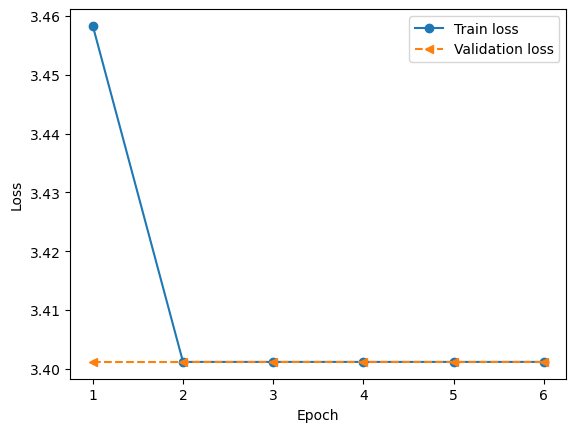

Training Accuracy: 0.0612441711127758
Validation Accuracy: 0.05655527114868164


In [28]:
# train model_tf on (X_train, y_train) data
### YOUR CODE HERE ###
history = model_1.fit(train_images_shuffled, train_labels_class_shuffled, epochs=10, validation_data=(val_images_shuffled, val_labels_class_shuffled), callbacks=[early_stopping])
print('Total params: ', model_1.count_params())

# plot loss curves
### YOUR CODE HERE ###
trained_model_epochs = history.history
x_arr = np.arange(len(trained_model_epochs['loss'])) + 1 
plt.plot(x_arr, trained_model_epochs['loss'], '-o', label='Train loss')
plt.plot(x_arr, trained_model_epochs['val_loss'], '--<', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
print('Training Accuracy:', trained_model_epochs['accuracy'][-1])
print('Validation Accuracy:', trained_model_epochs['val_accuracy'][-1])

In [29]:
print('Test Accuracy:', model_1.evaluate(test_images_shuffled, test_labels_class_shuffled)[-1])

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0206 - loss: 3.4012
Test Accuracy: 0.024175824597477913


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 224, 224, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │    24,084,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,118,910 (92.01 MB)

 Trainable params: 24,118,910 (92.01 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.3400 - loss: 254.5253 - val_accuracy: 0.4055 - val_loss: 2.0766
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1029s 3s/step - accuracy: 0.4054 - loss: 2.0804 - val_accuracy: 0.4055 - val_loss: 2.0771
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.4054 - loss: 2.0812 - val_accuracy: 0.4055 - val_loss: 2.0774
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 772s 2s/step - accuracy: 0.4054 - loss: 2.0815 - val_accuracy: 0.4055 - val_loss: 2.0775
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.4054 - loss: 2.0817 - val_accuracy: 0.4055 - val_loss: 2.0776
Epoch 6/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 767s 2s/step - accuracy: 0.4054 - loss: 2.0818 - val_accuracy: 0.4055 - val_loss: 2.0776
Epoch 7/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 910s 2s/step - accuracy: 0.4054 - loss: 2.0819 - val_accuracy: 0.4055 - val_loss: 2.0777
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
Total 

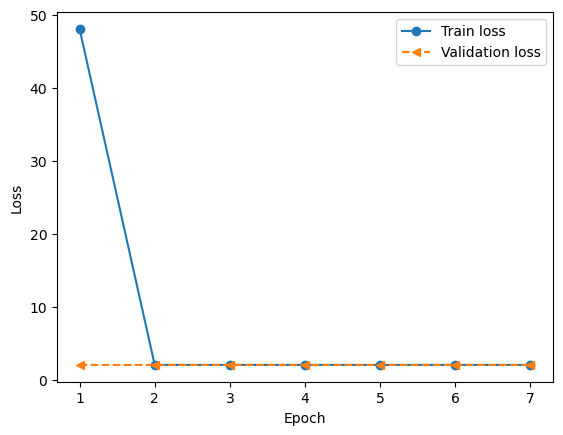

Training Accuracy: 0.4058833122253418
Validation Accuracy: 0.4055269956588745


In [30]:
# initialize model
model_2 = tf.keras.Sequential()

# add convolutional layer
### YOUR CODE HERE ###
model_2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(1,1), padding='same', name='conv_1', activation='relu'))
model_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), padding='same', name='conv_2', activation='relu'))

# add max pooling layer 
### YOUR CODE HERE ###
model_2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# add dropout layer
### YOUR CODE HERE ###
model_2.add(tf.keras.layers.Dropout(rate=0.3))

# add a flattening layer
### YOUR CODE HERE ###
model_2.add(tf.keras.layers.Flatten())

# add the classification layer
### YOUR CODE HERE ###
num_classes = len(set(train_labels_class_shuffled))
model_2.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# build and compile model
model_2.build(input_shape=(None, 224, 224, 3))
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

# print model_tf summary
### YOUR CODE HERE ###
print(model_2.summary())

# train model_tf on (X_train, y_train) data
### YOUR CODE HERE ###
trained_model = model_2.fit(train_images_shuffled, train_labels_class_shuffled, epochs=10, validation_data=(val_images_shuffled, val_labels_class_shuffled), callbacks=[early_stopping])
print('Total params: ', model_2.count_params())

# plot loss curves
### YOUR CODE HERE ###
trained_model_epochs = trained_model.history
x_arr = np.arange(len(trained_model_epochs['loss'])) + 1 
plt.plot(x_arr, trained_model_epochs['loss'], '-o', label='Train loss')
plt.plot(x_arr, trained_model_epochs['val_loss'], '--<', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
print('Training Accuracy:', trained_model_epochs['accuracy'][-1])
print('Validation Accuracy:', trained_model_epochs['val_accuracy'][-1])

In [31]:
print('Test Accuracy:', model_2.evaluate(test_images_shuffled, test_labels_class_shuffled)[-1])

72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - accuracy: 0.1530 - loss: 2.5103
Test Accuracy: 0.15296703577041626


In [15]:
def build_FFNN_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(224,224,3)))  # input shape is 224x224 based on the images
    model.add(tf.keras.layers.Flatten())  # flatten the 224x224x3 to 1D array
    for hidden_layer_size in hidden_layer_sizes:  # iterate through each hidden layer and add them to the model with the associated activation function
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation))
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))  # add the final output layer with the softmax activation function (since this is a multi-class classification problem)

    if optimizer == 'SGD':
        optimizer_func = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer_func = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError('Unknown optimizer')
    
    model.compile(loss='sparse_categorical_crossentropy',  # compile the model with the desired optimizer function
                    optimizer=optimizer_func,
                    metrics=[metric])

    return model

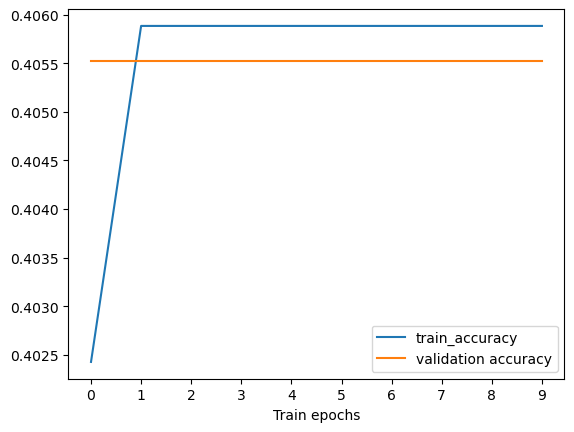

Training accuracy: 0.4059
Validation accuracy: 0.4055


In [16]:
# final model with preferred parameters
def train_and_evaluate(hidden_layer_sizes=[256,128,64],  #[50176]
                       activation='relu',
                       optimizer='SGD',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    num_classes = len(set(train_labels_class_shuffled))
    model = build_FFNN_model(n_classes=num_classes,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

  # Select the dataset.
    X_train = train_images_shuffled
    X_test = test_images_shuffled
    Y_train = train_labels_class_shuffled
    Y_test = test_labels_class_shuffled

  # Train the model.
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_data=(val_images_shuffled, val_labels_class_shuffled),
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model


# run the function
model_3 = train_and_evaluate()

In [17]:
results_model_3_train = model_3.evaluate(train_images_shuffled, train_labels_class_shuffled)
print("training accuracy (test):", results_model_3_train[-1])
results_model_3_test = model_3.evaluate(test_images_shuffled, test_labels_class_shuffled)
print("test accuracy (test):", results_model_3_test[-1])

389/389 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.3958 - loss: 2.0787
training accuracy (test): 0.4058833122253418
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1612 - loss: 2.4795
test accuracy (test): 0.15296703577041626


In [33]:

print(f"Unique train variables: {np.unique(train_variables_shuffled[:,0])}")
print(f"Unique train variables: {np.unique(train_variables_shuffled[:,1])}")
print(len(np.unique(train_variables_shuffled[:,1])))

print("Habitat (train):", train_variables_shuffled[:, 1][:5])
print("Habitat (val):", val_variables_shuffled[:, 1][:5])
print("Unique Habitat Values:", np.unique(train_variables_shuffled[:, 1]))

Unique train variables: [b'0.0' b'0.25' b'1.0' b'10.0' b'100.0' b'101.0' b'102.0' b'103.0'
 b'104.0' b'105.0' b'106.0' b'107.0' b'108.0' b'1080.0' b'109.0' b'1094.0'
 b'1095.0' b'11.0' b'110.0' b'1105.0' b'111.0' b'1116.0' b'112.0' b'113.0'
 b'114.0' b'1144.0' b'115.0' b'1152.0' b'1157.0' b'116.0' b'1166.0'
 b'117.0' b'1173.0' b'118.0' b'1185.0' b'1186.0' b'119.0' b'1193.0'
 b'12.0' b'120.0' b'121.0' b'122.0' b'123.0' b'124.0' b'1242.0' b'125.0'
 b'126.0' b'127.0' b'128.0' b'129.0' b'13.0' b'130.0' b'131.0' b'132.0'
 b'133.0' b'134.0' b'135.0' b'136.0' b'137.0' b'138.0' b'139.0' b'14.0'
 b'142.0' b'1422.0' b'144.0' b'1443.0' b'145.0' b'146.0' b'147.0' b'149.0'
 b'15.0' b'150.0' b'151.0' b'152.0' b'153.0' b'154.0' b'155.0' b'156.0'
 b'157.0' b'1576.0' b'16.0' b'160.0' b'1600.0' b'162.0' b'163.0' b'164.0'
 b'165.0' b'166.0' b'168.0' b'17.0' b'170.0' b'172.0' b'173.0' b'174.0'
 b'178.0' b'18.0' b'183.0' b'184.0' b'189.0' b'19.0' b'192.0' b'196.0'
 b'198.0' b'2.0' b'2.25' b'20.0' b'201.0' 

In [99]:
# Decode byte strings to regular strings
elevation_int_train = [x.decode('utf-8') if isinstance(x, bytes) else x for x in train_variables_shuffled[:, 0]]
elevation_int_val = [x.decode('utf-8') if isinstance(x, bytes) else x for x in val_variables_shuffled[:, 0]]
elevation_int_test = [x.decode('utf-8') if isinstance(x, bytes) else x for x in test_variables_shuffled[:, 0]]
# Replace 'nan' or invalid values with a default value (e.g., -1)
elevation_int_train = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_train]
elevation_int_val = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_val]
elevation_int_test = [int(float(x)) if x != 'nan' else -1 for x in elevation_int_test]

# Decode byte strings to regular strings
habitat_str_train = [x.decode('utf-8') if isinstance(x, bytes) else x for x in train_variables_shuffled[:, 1]]
habitat_str_val = [x.decode('utf-8') if isinstance(x, bytes) else x for x in val_variables_shuffled[:, 1]]
habitat_str_test = [x.decode('utf-8') if isinstance(x, bytes) else x for x in test_variables_shuffled[:, 1]]

In [100]:
print(f"Unique train variables: {np.unique(elevation_int_train)}")
print(f"Unique train variables: {np.unique(habitat_str_train)}")
print(len(np.unique(habitat_str_train)))

Unique train variables: [  -1    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38   39   40
   41   42   43   44   45   46   47   48   49   50   51   52   53   54
   55   56   57   58   59   60   61   62   63   64   65   66   67   68
   69   70   71   72   73   74   75   76   77   78   79   80   81   82
   83   84   85   86   87   88   89   90   91   92   93   94   95   96
   97   98   99  100  101  102  103  104  105  106  107  108  109  110
  111  112  113  114  115  116  117  118  119  120  121  122  123  124
  125  126  127  128  129  130  131  132  133  134  135  136  137  138
  139  142  144  145  146  147  149  150  151  152  153  154  155  156
  157  160  162  163  164  165  166  168  170  172  173  174  178  183
  184  189  192  196  198  201  203  206  211  214  217  218  219  220
  221  223  225  228  231  233  238  240  242  243  2

In [106]:
# remove -1 from elevation_int_train and all other variables
valid_indices = [i for i, x in enumerate(elevation_int_train) if x != -1]
train_images_shuffled = train_images_shuffled[valid_indices]
train_labels_class_shuffled = train_labels_class_shuffled[valid_indices]
train_variables_shuffled = train_variables_shuffled[valid_indices]
elevation_int_train = elevation_int_train[valid_indices]
habitat_str_train = habitat_str_train[valid_indices]

IndexError: index 12288 is out of bounds for axis 0 with size 12288

In [ ]:
elevation_int_train = np.array(elevation_int_train, dtype=int)
elevation_int_val = np.array(elevation_int_val, dtype=int)
elevation_int_test = np.array(elevation_int_test, dtype=int)

habitat_str_train = np.array(habitat_str_train, dtype=str)
habitat_str_val = np.array(habitat_str_val, dtype=str)
habitat_str_test = np.array(habitat_str_test, dtype=str)

In [ ]:
def build_multimodal_CNN():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  image = tf.keras.layers.Input(shape=(224, 224, 3), name='image')
  elevation = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='elevation')
  habitat = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='habitat')
  num_classes = len(set(train_labels_class_shuffled))

  # Process image input (CNN)
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(1,1), padding='same', name='conv_1', activation='relu')(image)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), padding='same', name='conv_2', activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
  x = tf.keras.layers.Dropout(rate=0.3)(x)
  x = tf.keras.layers.Flatten()(x)
  
  # Process elevation input (normalize)
  elevation_normalized = tf.keras.layers.Normalization()(elevation)

  # Process habitat input (embedding)
  embed_dim = len(np.unique(habitat_str_train)) + 1
  habitat_lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(habitat_str_train), output_mode='int')(habitat)
  # ['Acidic oak woodland', 'Bog woodland', 'Deciduous woodland', 'Forest bog', 'Mixed woodland (with coniferous and deciduous trees)', 'Thorny scrubland', 'Unmanaged coniferous woodland', 'Unmanaged deciduous woodland', 'Willow scrubland', 'bog', 'coniferous woodland/plantation', 'ditch', 'dune', 'fallow field', 'fertilized field in rotation', 'garden', 'gravel or clay pit', 'heath', 'hedgerow', 'improved grassland', 'lawn', 'masonry', 'meadow', 'natural grassland', 'other habitat', 'park/churchyard', 'roadside', 'rock', 'roof', 'salt meadow', 'wooded meadow, grazing forest']
  habitat_embedding = tf.keras.layers.Embedding(input_dim=embed_dim, output_dim=8)(habitat_lookup)
  habitat_embedding = tf.keras.layers.Flatten()(habitat_embedding)

  # Concatenate all features
  combined_features = tf.keras.layers.Concatenate()([x, elevation_normalized, habitat_embedding])  # can also do tf.keras.layers.Add()

  # Dense layers for classification
  dense = tf.keras.layers.Dense(128, activation="relu")(combined_features)
  output = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

  # Build the model
  model = tf.keras.Model(inputs=[image, elevation, habitat], outputs=output)

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  # Print the model summary
  model.summary()

  return model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 224, 224,  │      1,568 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 224, 224,  │     32,832 │ conv_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ habitat             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv_2[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup       │ (None, 1)         │          0 │ habitat[0][0]     │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elevation           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │        256 │ string_lookup[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 802816)    │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 1)         │          3 │ elevation[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 802825)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ normalization[0]… │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 102,761,7… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │      3,870 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,800,257 (392.15 MB)

 Trainable params: 102,800,254 (392.15 MB)

 Non-trainable params: 3 (16.00 B)

python(42067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


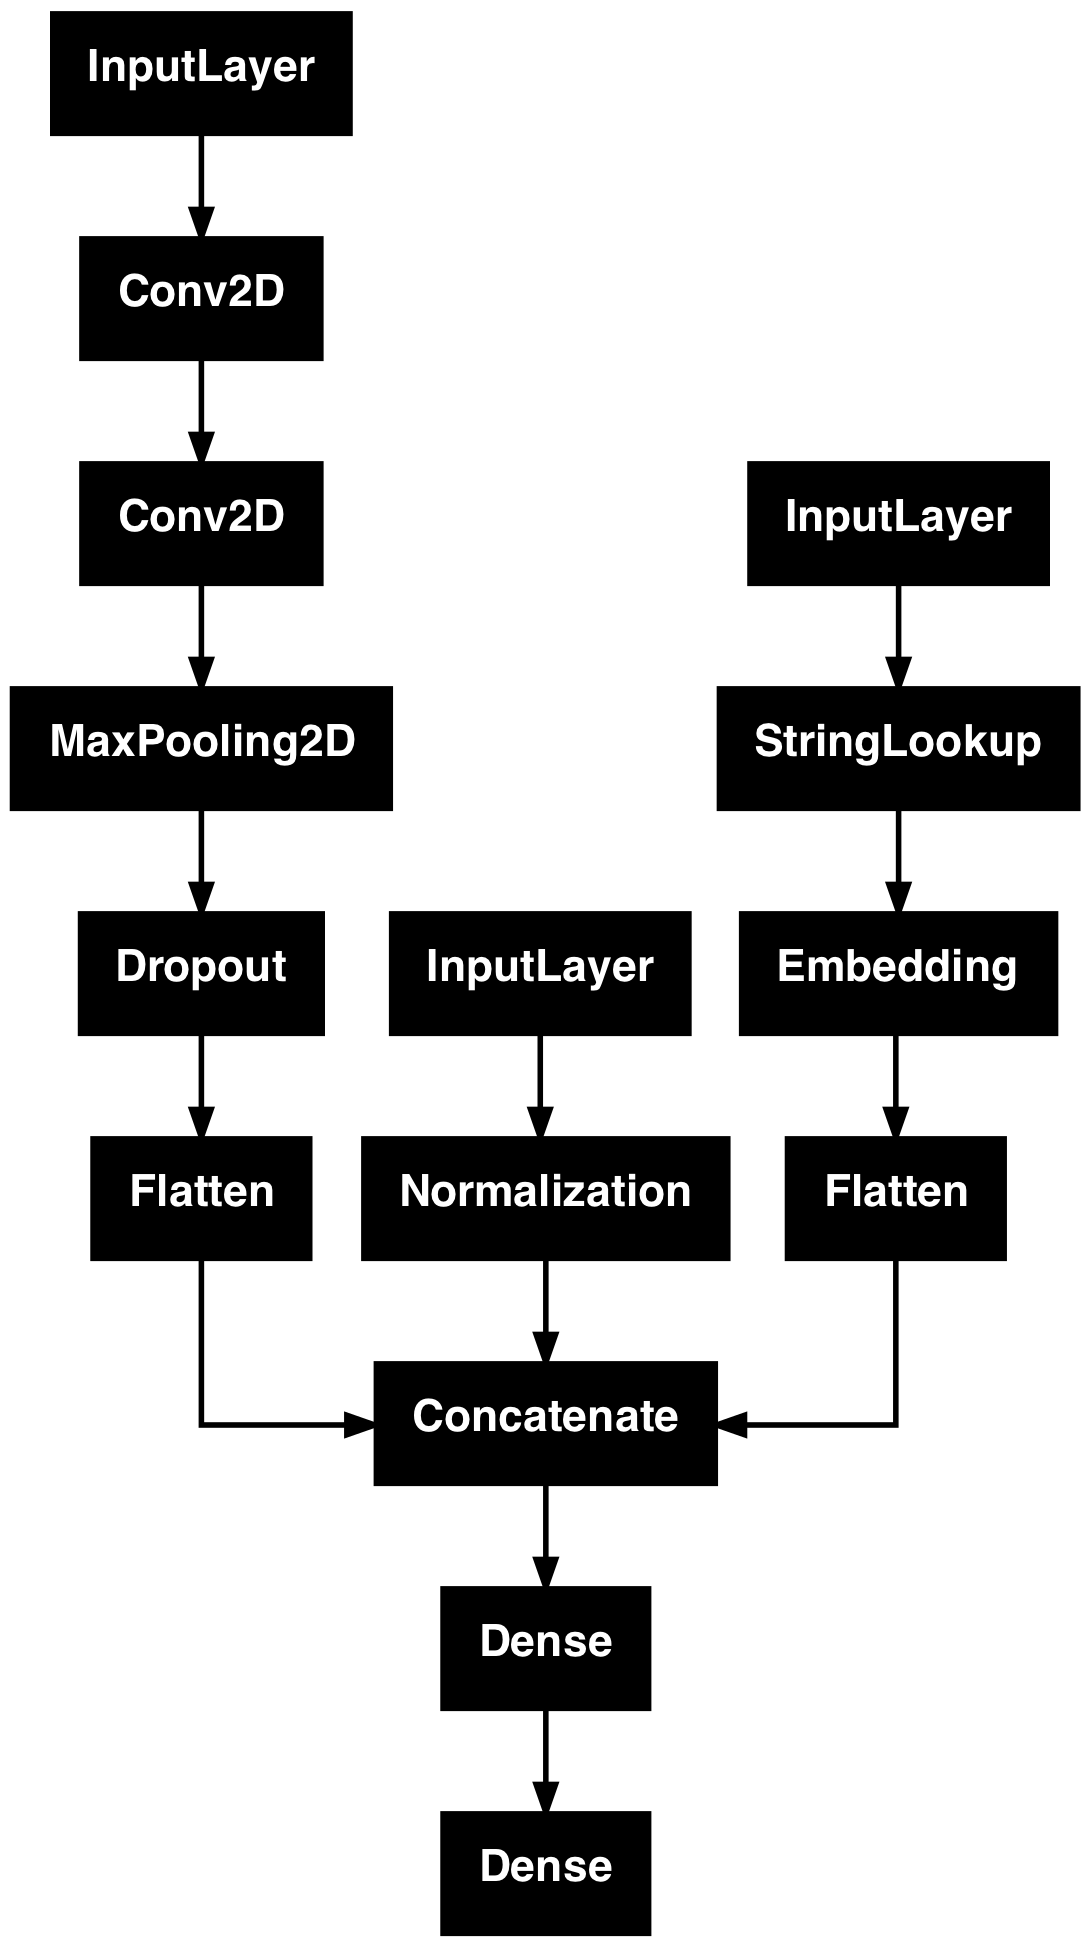

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 12442, 12442, 12288
'y' sizes: 12288


In [ ]:
model_4 = build_multimodal_CNN()
display(tf.keras.utils.plot_model(model_4))

history = model_4.fit(
  x={
      'image': train_images_shuffled,
      'elevation': elevation_int_train.reshape(-1, 1),
      'habitat': habitat_str_train.reshape(-1, 1),
    },
  y=train_labels_class_shuffled,
  epochs=10,
  batch_size=64,
  validation_data=(
      {
        'image': val_images_shuffled,
        'elevation': elevation_int_val.reshape(-1, 1),
        'habitat': habitat_str_val.reshape(-1, 1),
      },
      val_labels_class_shuffled),
  verbose=0)


# plot loss curves
### YOUR CODE HERE ###
history_epochs = history.history
x_arr = np.arange(len(history_epochs['loss'])) + 1 
plt.plot(x_arr, history_epochs['loss'], '-o', label='Train loss')
plt.plot(x_arr, history_epochs['val_loss'], '--<', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
print('Training Accuracy:', history_epochs['accuracy'][-1])
print('Validation Accuracy:', history_epochs['val_accuracy'][-1])

In [60]:
print(habitat_str_train[:10])  # Inspect the first 10 values
print(type(habitat_str_train))  # Check the type of the data
print(habitat_str_train.dtype)  # Check the dtype of the NumPy array

['Mixed woodland (with coniferous and deciduous trees)' 'park/churchyard'
 'Deciduous woodland' 'Deciduous woodland' 'Thorny scrubland'
 'Willow scrubland' 'Mixed woodland (with coniferous and deciduous trees)'
 'Thorny scrubland' 'park/churchyard' 'wooded meadow, grazing forest']
<class 'numpy.ndarray'>
object


In [105]:
print(f"train_images_shuffled shape: {train_images_shuffled.shape}")
print(f"elevation_int_train shape: {elevation_int_train.shape}")
print(f"habitat_str_train shape: {habitat_str_train.shape}")
print(f"train_labels_class_shuffled shape: {train_labels_class_shuffled.shape}")

train_images_shuffled shape: (12288, 224, 224, 3)
elevation_int_train shape: (12442,)
habitat_str_train shape: (12442,)
train_labels_class_shuffled shape: (12288,)
